<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_10_Models_for_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing models for full dataset
---

## Import packages

In [2]:
# General
import numpy as np
import time
import os

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# For prediction model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

## Load dataset

In [3]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading a dataset!')
    return pd.read_csv(data)

In [4]:
filenames = os.listdir('./Data')
url_1 = './Data/' + filenames[0]
df = url2pd(url_1)
df.info()
df.head(3)

Done loading a dataset!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vehicle_ID    1048575 non-null  int64  
 1   Frame_ID      1048575 non-null  int64  
 2   Total_Frames  1048575 non-null  int64  
 3   Global_Time   1048575 non-null  int64  
 4   Local_X       1048575 non-null  float64
 5   Local_Y       1048575 non-null  float64
 6   Global_X      1048575 non-null  float64
 7   Global_Y      1048575 non-null  float64
 8   v_Length      1048575 non-null  float64
 9   v_Width       1048575 non-null  float64
 10  v_Class       1048575 non-null  int64  
 11  v_Vel         1048575 non-null  float64
 12  v_Acc         1048575 non-null  float64
 13  Lane_ID       1048575 non-null  int64  
 14  Preceeding    1048575 non-null  int64  
 15  Following     1048575 non-null  int64  
 16  Space_Hdwy    1048575 non-null  float64
 17  Tim

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,2,13,437,1118846980200,16.467196,35.380427,6451137.641,1873344.962,14.5,4.9,2,40.000000,0.000000,2,0,0,0.0,0.0
1,2,14,437,1118846980300,16.446594,39.381608,6451140.329,1873342.000,14.5,4.9,2,40.012349,0.123485,2,0,0,0.0,0.0
2,2,15,437,1118846980400,16.425991,43.381541,6451143.018,1873339.038,14.5,4.9,2,39.999855,-0.124939,2,0,0,0.0,0.0


Let's take a glance at the data. Here are the first few rows:

In [5]:
# Filter time step
print(df.shape)
df = df.iloc[::2,:].copy()
df.reset_index(drop=True, inplace=True)
print('After filtering:', df.shape)
#  keep only columns that are useful for now
kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID']
df = df[kept_cols]
df.head()

(1048575, 18)
After filtering: (524288, 18)


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [6]:
'the number of vehicles is {}'.format(len(df.Vehicle_ID.unique()))

'the number of vehicles is 1993'

# Model 1

### Constant values

In [7]:
# Set constant values
HISTORY_LENGTH = 3
FUTURE_LENGTH = 6
n_steps = int(HISTORY_LENGTH/0.2)
n_future = int(FUTURE_LENGTH/0.2)
n_features = len(df)
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
vehicle_ids = df.Vehicle_ID.unique()

## Data preparation

### `series2seq`: Function that return sequence input and output for one object

**Arguments**:
series,past=4,future=1,past_step=1, future_step=1
- series:  A Sequence of observations as a numpy array or list.
- past: Number of lag observations as input (X).
- future: Number of observations as output (y).
- past_step, future_step: increments of input or output
    
**Returns**:
- X, Y: Features and Labels Numpy array

  

In [8]:
# Test data frame
# data set of the vehicle #2
df_test = df[df.Vehicle_ID==vehicle_ids[0]].copy()
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    219 non-null    int64  
 1   Frame_ID      219 non-null    int64  
 2   Total_Frames  219 non-null    int64  
 3   Local_X       219 non-null    float64
 4   Local_Y       219 non-null    float64
 5   v_Length      219 non-null    float64
 6   v_Width       219 non-null    float64
 7   v_Class       219 non-null    int64  
 8   v_Vel         219 non-null    float64
 9   v_Acc         219 non-null    float64
 10  Lane_ID       219 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 20.5 KB


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [9]:
def single_series2seq(series,past=4,future=1,past_step=1, future_step=1):
    # length of sequences 
    length = past + future
    seq = series.copy()
    # add rolled series
    for i in range(length-1):
        seq = np.vstack((seq,np.roll(series,i+1)))
    seq = np.flip(seq.T,1)
    seq = seq[length-1:,:]
    # Prepare output
    X = seq[:,:past:past_step]
    Y = seq[:,past::future_step]
    return X,Y
data = np.arange(20)
single_series2seq(data,past = 3, future = 4,future_step=1)

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12],
        [11, 12, 13],
        [12, 13, 14],
        [13, 14, 15]]),
 array([[ 3,  4,  5,  6],
        [ 4,  5,  6,  7],
        [ 5,  6,  7,  8],
        [ 6,  7,  8,  9],
        [ 7,  8,  9, 10],
        [ 8,  9, 10, 11],
        [ 9, 10, 11, 12],
        [10, 11, 12, 13],
        [11, 12, 13, 14],
        [12, 13, 14, 15],
        [13, 14, 15, 16],
        [14, 15, 16, 17],
        [15, 16, 17, 18],
        [16, 17, 18, 19]]))

In [10]:
inputs, labels = single_series2seq(df_test.Local_X,past = n_steps, future = n_future,future_step=5)
df_test.Local_X.shape, inputs.shape, labels.shape

((219,), (175, 15), (175, 6))

In [11]:
def multi_series2seq(mulseries,**kwarg):
    # number of series
    n_series = mulseries.shape[1]
    seq = mulseries.copy()
    X,Y = single_series2seq(seq[:,0],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
    for i in range(1,n_series):
        newX,newY = single_series2seq(seq[:,i],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        X = np.column_stack((X,newX))
        Y = np.column_stack((Y,newY))
    return X,Y
data = np.arange(20).reshape(-1,2)
multi_series2seq(mulseries = data,past = 3, future = 4,future_step=1)

(array([[ 0,  2,  4,  1,  3,  5],
        [ 2,  4,  6,  3,  5,  7],
        [ 4,  6,  8,  5,  7,  9],
        [ 6,  8, 10,  7,  9, 11]]),
 array([[ 6,  8, 10, 12,  7,  9, 11, 13],
        [ 8, 10, 12, 14,  9, 11, 13, 15],
        [10, 12, 14, 16, 11, 13, 15, 17],
        [12, 14, 16, 18, 13, 15, 17, 19]]))

In [12]:
inputs, labels = multi_series2seq(df_test[['Local_X','v_Vel']].values ,past = n_steps, future = n_future,future_step=5)
df_test[['Local_X','v_Vel']].shape, inputs.shape, labels.shape

((219, 2), (175, 30), (175, 12))

### `treatment_cars` Function to prepare the data set for each car

In [13]:
# Test data frame
# data set of the first 5 vehicles
df_test = df[df.Vehicle_ID.isin(vehicle_ids[:5])].copy()
df_test.info()
print(df_test.Vehicle_ID.unique())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    1023 non-null   int64  
 1   Frame_ID      1023 non-null   int64  
 2   Total_Frames  1023 non-null   int64  
 3   Local_X       1023 non-null   float64
 4   Local_Y       1023 non-null   float64
 5   v_Length      1023 non-null   float64
 6   v_Width       1023 non-null   float64
 7   v_Class       1023 non-null   int64  
 8   v_Vel         1023 non-null   float64
 9   v_Acc         1023 non-null   float64
 10  Lane_ID       1023 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 95.9 KB
[2 4 5 6 8]


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [14]:
# multiple objects
def multi_obj2seq(data, **kwarg):
    veh_ids = data.Vehicle_ID.unique()
    X,Y = np.array([]), np.array([])
    for id in veh_ids:
        dat = data[data.Vehicle_ID==id][target_names].copy()
        newX,newY = multi_series2seq(dat.values ,past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        #print(X.shape, newX.shape)
        X = np.vstack((X,newX)) if X.size else newX
        Y = np.vstack((Y,newY)) if Y.size else newY
        #print(X.shape)
    if kwarg["show_result"]:
        print(X.shape)
        print(Y.shape)
    return X, Y
inputs, labels = multi_obj2seq(df_test,past = n_steps, future = n_future,future_step=5, show_result=True)

(803, 30)
(803, 12)


### Choose the size of the raw data set

In [15]:
%%time
inputs, labels = multi_obj2seq(df,past = n_steps, future = n_future,future_step=5, show_result=True)

(436596, 30)
(436596, 12)
CPU times: user 37.5 s, sys: 24.6 s, total: 1min 2s
Wall time: 1min 2s


### Split the data set


In [16]:
X_train, X_test, y_train, y_test = train_test_split(inputs,labels, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(305617, 30) (130979, 30) (305617, 12) (130979, 12)


In [17]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.mean(), X_train.std()

(305617, 30)


(5.376179717569043e-16, 1.0000000000000004)

In [18]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))


In [19]:
X_train.shape,X_test.shape

((305617, 30, 1), (130979, 30, 1))

In [22]:
y_train.shape

(305617, 12)

## Prediction model

In [23]:
%%time
# define model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=50, batch_size= 1024,
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Train on 305617 samples, validate on 130979 samples
Epoch 1/50
305617/305617 [==============================] - 6s 21us/sample - loss: 841.1080 - val_loss: 507.6231
Epoch 2/50
305617/305617 [==============================] - 2s 6us/sample - loss: 375.3658 - val_loss: 289.9691
Epoch 3/50
305617/305617 [==============================] - 2s 6us/sample - loss: 246.6941 - val_loss: 195.7656
Epoch 4/50
305617/305617 [==============================] - 2s 6us/sample - loss: 150.4981 - val_loss: 123.2594
Epoch 5/50
305617/305617 [==============================] - 2s 6us/sample - loss: 105.3497 - val_loss: 90.2383
Epoch 6/50
305617/305617 [==============================] - 2s 6us/sample - loss: 77.9447 - val_loss: 67.5359
Epoch 7/50
305617/305617 [==============================] - 2s 6us/sample - loss: 58.5850 - val_loss: 51.2189
Epoch 8/50
305617/305617 [==============================] - 2s 6us/sample - loss: 44.6699 - val_loss: 39.5157
Epoch 9/50
305617/305617 [==============================] 

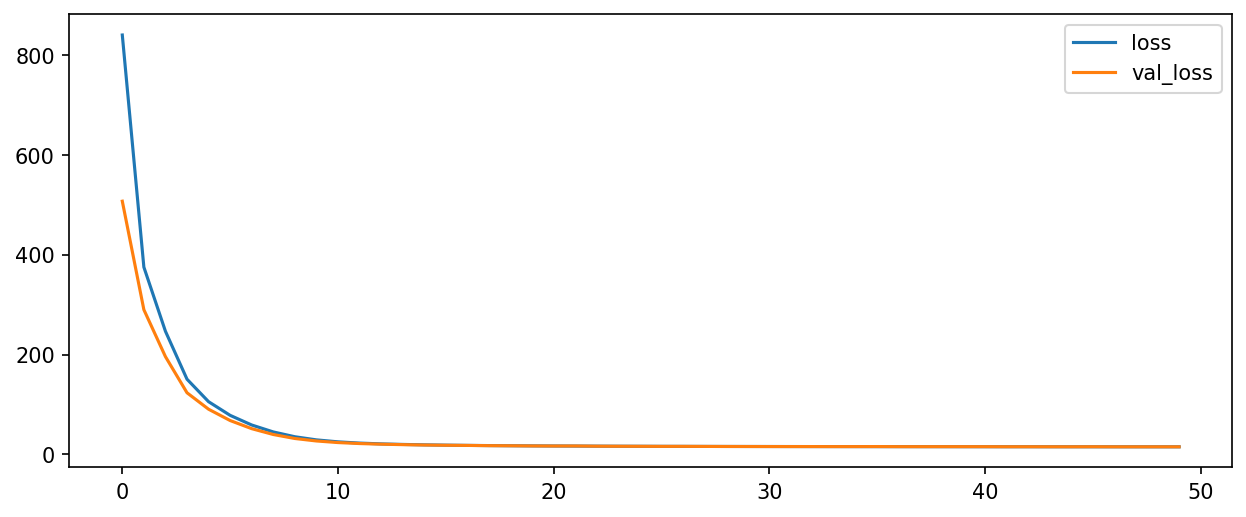

In [26]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes)
#hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

## Evaluation 


In [27]:
y_hat = model.predict(X_test, verbose=1)
colnames = [str(i)+'s' for i in range(6)]
rmse = np.sqrt(np.square(np.subtract(y_test,y_hat)).mean(0)).reshape(2,-1)
rmse = pd.DataFrame(rmse,columns = colnames, index = target_names )
rmse.round(3)

130979/130979 [==============================] - 10s 73us/sample


,0s,1s,2s,3s,4s,5s
Local_X,0.648,0.945,1.244,1.512,1.767,2.008
v_Vel,0.713,3.411,4.449,5.572,6.627,7.626


# END